# ACSE-7 (Optimisation & Inversion) <a class="tocSkip"></a>

## Coursework part B <a class="tocSkip"></a>

Part B of the coursework covers lectures 2-7. The completion time should be roughly that of part A and part C combined.

<font size="1pt">Some $\LaTeX$ definitions hidden in this cell (double-click to reveal)</font>
$
\newcommand\vec[1]{\boldsymbol{\mathrm{#1}}}
\newcommand\mat[1]{\underline{\mathbf{#1}}}
\newcommand\R{\mathbb{R}}
\newcommand\vlam{\boldsymbol{\lambda}}
$

In [1]:
# needs to be in separate cell!
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# scipy's optimization
import scipy.optimize as sop
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl

# font sizes for plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

## From Poisson to Diffusion Equation <a class="tocSkip"/></a>

In the lectures, we have used a finite difference discretisation of Poisson's equation in two dimensions:

$$
  -\frac{\partial^2 u(x,y)}{\partial x^2} - \frac{\partial^2 u(x,y)}{\partial y^2} = f(x,y)
$$

with a Finite Difference discretisation given by:


$$ \frac{-u_{i-1} + 2u_{i} -u_{i+1}}{\Delta x^2} + \frac{-u_{i-N_x} + 2u_{i} - u_{i+N_x}}{\Delta y^2} = f_i $$

where we assume a computational grid of $N_y$ rows and $N_x$ columns, giving $n=N_x\cdot N_y$ grid points. The grid values $u_i$ are numbered row by row. The values $u_{i-1}$ and $u_{i+1}$ refer to the values to the left and right of $u_i$ respectively, whereas $u_{i-N_x}$ and $u_{i+N_x}$ refer to value in the row above and below. We will assume $\Delta y=\Delta x$. In matrix form we may write

$$
  \mat K \vec u = \vec f
$$

with for each row $i$ associated with a grid point in the interior (away from the boundary):

$$
  K_{i,i} = \frac{4}{\Delta x^2}, \text{ and }
  K_{i,i-N_x} = K_{i,i-1} = K_{i,i+1} = K_{i,i+N_x} = -\frac 1{\Delta x^2}
$$

For the boundary rows, we imposed Dirichlet boundary conditions, and we stated, without proof, that the resulting matrix is Symmetric Positive Definite.

# Question B1

* What is your recommendation for a Krylov Subspace method to solve this linear system. Describe in one or two sentences why this method requires the matrix to be SPD.

***

### Answer B1
- Conjugate Gradient Method
- If the matrix is SPD the quadratic function is convex and it has a unique local minimum solution, so we have to require the matrix to be SPD.

# Question B2


Note that for the rows associated with interior points, we have

$$
  \sum_{j=1}^n K_{ij} = 0
$$

i.e. the sum of the entries in each interior row is zero. If we apply Neumann (instead of Dirichlet) boundary conditions, the same is true for all rows: both boundary and interior rows sum to zero.

* Is the matrix with Neumann boundary condition still Symmetric Positive Definite? **Hint:** consider a vector $\vec v$ whose values are all the same: $v_i=C$ for all $i$ with some constant $C$, and compute $\vec v^T\mat K\vec v$. Assuming the matrix is symmetric, and that for all other vectors $\vec v$ we still have $\vec v^T\mat K\vec v\gt 0$, what other term *does* apply to this matrix?

***

$$
\vec v = \begin{pmatrix}
C\\
C\\
\vdots\\
C
\end{pmatrix}
$$


$$
\mat\kappa = 
\begin{pmatrix}
\kappa_{11}&\kappa_{12}&\cdots&\kappa_{1n}\\
\kappa_{21}&\kappa_{22}&\cdots&\kappa_{2n}\\
\vdots & \vdots & \ddots  & \cdots\\
\kappa_{n1}&\kappa_{n2}&\cdots&\kappa_{nn}
\end{pmatrix}
$$


$$
\vec v^T\mat K\vec v = 
\begin{pmatrix}
C & C & \cdots &C
\end{pmatrix}
\begin{pmatrix}
\kappa_{11}&\kappa_{12}&\cdots&\kappa_{1n}\\
\kappa_{21}&\kappa_{22}&\cdots&\kappa_{2n}\\
\vdots & \vdots & \ddots  & \cdots\\
\kappa_{n1}&\kappa_{n2}&\cdots&\kappa_{nn}
\end{pmatrix}
\begin{pmatrix}
C\\
C\\
\vdots\\
C
\end{pmatrix}
=C^{2}
\begin{pmatrix}
\sum K_{ij}
\end{pmatrix}
= 0
$$

* From the caculation above we can see that $\vec v^T \mat K \vec v = 0$, and no matter how we change $\vec v$ we still have $\vec v^T \mat K \vec v = 0$.From the definition of SPD and Positive Semi-Definite,matrix $\mat K$ is Positive Semi-Definite,**so $\mat K$ with Neumann boundary condition is not SPD.**
* no matter what other term apply to this matrix $\vec v^T \mat K \vec v = 0$, the matrix $\mat K$ is still Positive Semi-Definite rather than **SPD**.

# Question B3


By adding a time derivative, we can turn this PDE into the diffusion equation

$$
  \frac{\partial u(x,y,t)}{\partial t} - m \frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2} = 0
$$

with diffusion coefficient $m$.

With an implicit time integration (backward Euler) the discrete equation looks like:
    
$$ 
\frac{u_i^{k+1} - u_i^k}{\Delta t} +
m\frac{-u_{i-1}^{k+1} + 2u_{i}^{k+1} -u_{i+1}^{k+1}}{\Delta x^2} + m\frac{-u_{i-N_x}^{k+1} + 2u_{i}^{k+1} - u_{i+N_x}^{k+1}}{\Delta y^2} = 0 $$

where the superscript ${}^{k+1}$ refers to the solution at the end of the timestep, and ${}^k$ to the value at the beginning of the timestep.

After multiplying all terms with $\Delta t$, we can write this discretisation as a linear system

$$
  \mat A \vec u^{k+1} = \vec u^k
$$

where the matrix $\mat A$ is given by

$$
  \mat A = \mat I + m~\Delta t~\mat K
$$

with identity matrix $\mat I$, and $\mat K$ the same matrix as we used for Poisson's equation above with Neumann conditions.

* Using what you already know about $\mat K$, proof that $\mat A$ is Symmetric Positive Definite.

***

### Answer B3

- $\mat I $ is identity matrix, so $\mat I$ is SPD. $m$ is diffusion coefficient, so m is positive scalar. $\Delta t$ is time interval, so $\Delta t$ is positive.From the conclusion of B2, we can get  $\vec v^T(m~\Delta t~\mat K)\vec v = 0 $ . For $\vec v^T(\mat I + m~\Delta t~\mat K)\vec v = \vec v^T \mat I \vec v = C^{2} \gt 0 \;\;\; \text{for all} \;\;\; \vec v\in{\mathbb{R}}^n,
\;\;\; \text{except } \;\;\;\vec v=0$ 


**so $\mat A $ is SPD.**

# Question B4

* We consider the use of dense vs. sparse matrices in solving this system. We use the Conjugate Gradient method to solve the linear system above on a series of computational grids where we increase the resolution and thus the number of grid points $n=N_x\cdot N_y$. We record the average time the CG method takes to perform a single iteration with the results displayed in the graph below. Describe the difference in terms of scaling for the case with dense matrices and the case with sparse matrices, and explain the reason why these differences can be observed. You only need to describe the asymptotic behaviour.

<img src='graph1.png'></img>

***

### Answer B4
* As we can observe the sparse matrix vector multiplication is much faster. In particular it is now a $O(n)$ operation instead of $O(n^2)$. This means the full Conjugate Gradient algorithm with $n$ iterations becomes just $O(n^2)$ instead of $O(n^3)$.
*Another important reason to use a more compact matrix format is that it takes a lot less memory to store. With $N_x=100$ grid points in both directions, we have $n=10^4$ grid points in total. The associated matrix therefore consists of $n^2=10^8$ entries. If we take into account that each floating point number in double precision takes 8 bytes of memory, that means the dense matrix takes up ~ 800 MB. The 5 diagonals stored separately on the other hand take up only 400 kB.

# Question B5

* As a stopping criterion we use a relative tolerance $\epsilon_{\text{rel}}=10^{-5}$. In the next two figures, we show the overall time for the Conjugate Gradient algorithm to converge with that criterion, and the number of iterations it takes. Only the results with a sparse matrix are shown. Again describe and explain the asymptotic behaviour of both graphs. You do not need to explain the specific value of the~ slope of 0.5 in the right-hand figure. Given that we can observe a slope of 0.5 however, what is your expectation of the scaling between the condition number of the matrix and $n$?

<img src="graph2.png"></img>

***

### Answer B5

* From lecture 5 we can know the relationship between condition number and iterations:
\begin{align*}
i &\leq \tfrac 12 \sqrt{\kappa(\mat A)} \ln \tfrac 2\epsilon & \text{ for Conjugate Gradient}
\end{align*}
if we use sparse matrices, the cost of number od iterations is $O(\sqrt{\kappa} n)$. So we can explain the number of CG iterations is O(n\cdot n^{1/2}).which can explain the right figure. In addition, we know that  $\kappa(\mat A)\propto N_x\cdot N_y=n$, i.e. the condition number scales linearly with n.
So from above information the computational time entire CG iterations 
is $O(n\cdot n^{1/2}) = O(n^{3/2})$ which can explain the left figure.
* From the part of Lecture 5, we know that $\kappa(\mat A)\propto N_x\cdot N_y=n$, so the expectation of scaling between the condition number of the matrix and n is $\kappa(\mat A)\propto N_x\cdot N_y=n$,

# Question B6

* We also measured the computational time for solving the linear system with a sparse direct method (not shown). We notice that the scaling of the computational time with the problem size $n$ was worse that linear. Explain why this is to be expected. Do you expect the scaling to be better, the same, or even worse when solving the same equation in three dimensions? Explain why.

***

#### We notice that the scaling of the computational time with the problem size 𝑛 was worse that linear. Explain why this is to be expected
- The performance of direct methods however can also be improved by taking the sparsity of the matrix into account but this is less straightforward. Initially the work is greatly reduced; for instance in the `Gaussian_elimination_upper` routine we still have an outer loop over all rows, but for each of these we only need to subtract it from rows below that have a corresponding nonzero column entry. Each row operation on its own is initially much cheaper as well as there are only a limited number of entries to work on. After some operations however, the matrix will acquire new nonzero entries (these are called <a class="definition" href=" " id="fillin">fill-in</a >) and slowly the matrix starts becoming dense so that the cost converges to that for dense matrices.

####  Do you expect the scaling to be better, the same, or even worse when solving the same equation in three dimensions? Explain why.

- As we can see the fill-in occurs between the initially furthest apart non-zero entries: $L_{ij}\neq 0$ for all $i-N_x\leq j\leq i$ and $U_{ij}\neq 0$ for all $i\leq j\leq i+N_x$. This means that the cost of the LU decomposition itself is roughly $O(n \times N_x \times N_x)=O(n^2)$. Once we have obtained the LU decomposition however it becomes cheaper to apply the inverse to multiple right-hand sides, i.e. solve $\mat L\mat U \vec x=\vec b$ for multiple vectors $\vec b$, since each of these solves is only $O(n \times N_x)=O(n^{1.5})$.

- Note that this complexity analysis is specific for the 2D problem that we are solving. For instance if we were solving the same problem in 3D with $n=N_x\times N_y\times N_z$ the complexity would be $O(n\times (N_x\times N_y)^2)=O(n^{2.333})$ for the constructing the LU decomposition and $O(n\times N_x\times N_y)=O(n^{1.666})$ for a subsequent solve of $\mat L\mat U\vec x=\vec b$.

# Diffusion Equation as Image Filter (background section - no question) <a class="tocSkip"></a>
The diffusion equation has many applications uch as the dispersal of microparticles through random motion (Brownian motion), the spread of a disolved substance, e.g. a pollutant in a fluid, or the spread of heat. We can also use it as a method to apply a blur effect to a photo.

First we read in a familiar looking photo:

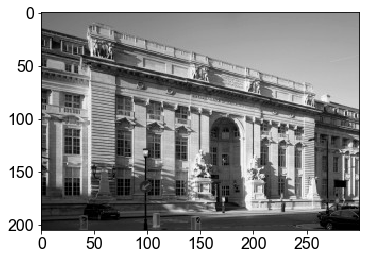

In [3]:
img = plt.imread("RSM-BW-300x205.png")
plt.imshow(img, cmap='gray');

The code to assemble the matrix $\mat A$ is given by:

In [4]:
def K_matrix(Nx, Ny, delta_x=1.0):
    """Assemble discrete Poisson matrix K
    
    Nx, Ny: number of gridpoint in x and y directions
    delta_x: grid distance
    """
    n = Ny * Nx
    K = sp.eye(n)*4  # main diagonal with the value 4
    K -= sp.eye(n, k=1)  # connections to grid point on the right
    K -= sp.eye(n, k=-1)  # connection to the left
    K -= sp.eye(n, k=Nx) # connection to grid point below
    K -= sp.eye(n, k=-Nx)  # connection above
    K = K / (delta_x)**2  # divide all entries by dx^2
        
    return K

def A_matrix(Nx, Ny, m, delta_t=1.0, delta_x=1.0):
    """Assemble discrete timestepping matrix A for diffusion equation
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient
    delta_t: time step
    delta_x: grid distance
    """
    n = Ny * Nx
    K = K_matrix(Nx, Ny, delta_x)
    A = sp.eye(n) + m * delta_t * K
        
    return A

So that a simple timestepping model takes the form:

In [5]:
def diffusion_model(Nx, Ny, m, u0, Nt, delta_t=1.0, delta_x=1.0):
    """Solve diffusion equation and return solution in final timestep
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    """

    A = A_matrix(Nx, Ny, m, delta_t=delta_t, delta_x=delta_x)
    u = u0
    for i in range(Nt):
        u = spl.spsolve(A, u)  # solve using sparse direct solver
    return u

In the rest of this coursework, we simply assume a fixed value for $\Delta x=1$, and also a timestep of $\Delta t=1$. The domain is assumed to be $[0,L]\times [0,H]$ with length $L=N_x\Delta x=N_x$ and height $H=N_y\Delta x=N_y$. The number of timesteps is given by $N_t$, and in the examples kept fixed at $N_t=5$, and we assume that the time $t$ runs between 0 and $T=N_t\Delta t=N_t$.

The code below shows how the diffusion model can be applied to a black and white photo. Note that we need to flatten the `img` array, which has a shape of $N_y\times N_x$, to a flat array `u` with length $n=N_x\cdot N_y$:

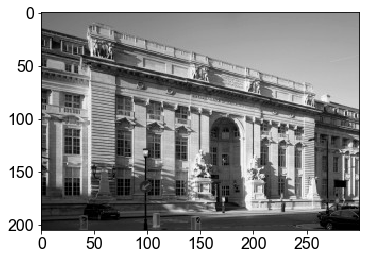

In [6]:
Ny, Nx = img.shape
Nt = 5
m = 0  # what value did we use ???
u0 = img.flatten()
u1 = diffusion_model(Nx, Ny, m, u0, Nt)
img1 = u1.reshape(Ny, Nx)
plt.imshow(img1, cmap='gray')
np.save('rsm-blurred.npy', img1)

# Question B7

## Inversion for Diffusion Coefficient <a class="tocSkip"/></a>
After applying the diffusion model, we have forgotten what value of the diffusion coefficient $m$ we have used. We do however still have the original photo that was used which served as the initial condition $u_{\text{ic}}$, and the blurred photo obtained from the last timestep value of $u$, which we have stored as $u_{\text{end}}$ (in the file `rsm-blurred.npy`). We therefore consider the following PDE-constrained optimisation problem:

$$
  \text{minimize } f(u, m) = \int \left(u(x, y, T) -u_{\text{end}}(x, y, T)\right)^2 \mathrm{d}x\mathrm{d}y
$$

subject to the PDE constraint:

$$
  g(u,m) = \begin{pmatrix}
    \frac{\partial u(x,y,t)}{\partial t} -m\frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2}  \\
    u(x, y, 0) - u_{\text{ic}}(x, y) \\
    \frac{\partial u(x,y,t)}{\partial x}  \\
    \frac{\partial u(x,y,t)}{\partial y} 
  \end{pmatrix}
  =
  \begin{pmatrix} 
  \phantom{\frac{\partial^2}{\partial x}} 0 \phantom{\frac{\partial^2}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} 
  \end{pmatrix}
  \begin{array}{l}
\text{ for } (x,y)\in [0,L]\times[0,H], t \in [0,T] \phantom{\frac{\partial^2}{\partial x}} \\
\text{ for } (x,y)\in [0,L]\times[0,H] \phantom{\frac{\partial u}{\partial x}} \\
    \text{ for } x=0\text{ or x=L, and } y\in [0,H], t \in [0,T] \phantom{\frac{\partial u}{\partial x}} \\
    \text{ for } y=0\text{ or y=H, and } x\in [0,L], t \in [0,T]
  \end{array}
$$

* We decide to use the tangent-linear approach to compute the gradient of the reduced functional. Consider a perturbation $\delta m$ in the diffusion coefficient $m$, show that the resulting perturbation $\delta u(x,y,t)$ to the solution $u(x,y,t)$ satisfies the following PDE:

$$
      \frac{\partial \delta u(x,y,t)}{\partial t} -m\frac{\partial^2 \delta u(x,y,t)}{\partial x^2} - m\frac{\partial^2 \delta u(x,y,t)}{\partial y^2} =
      \delta m\frac{\partial^2 u(x,y,t)}{\partial x^2} + \delta m\frac{\partial^2 u(x,y,t)}{\partial y^2}      
$$

with initial condition

$$
  \delta u(x,y,0) = 0
$$

and boundary conditions

\begin{align*}
    \frac{\partial \delta u(x,y,t)}{\partial x} &= 0 & \text{ for } x=0\text{ or x=L, and } y\in [0,H] \\
    \frac{\partial \delta u(x,y,t)}{\partial y} &= 0 &
    \text{ for } y=0\text{ or y=H, and } x\in [0,L]
\end{align*}

***

* In the lecture notes we saw that in the tangent linear approach we need to solve

$$
  \frac{\partial g}{\partial u}\delta u = -\frac{\partial g}{\partial m}\delta m
$$

to obtain the perturbation $\delta u$ in $u$ due to a perturbation $\delta m$ in $m$. In other words:

$$
  \delta u = \frac{du}{dm} \delta m
$$

Then we can work out what the PDE is for $\delta u$, including initial and boundary conditions:


We have

$$
  \frac{\partial g(u, m)}{\partial u} \delta u = \begin{pmatrix}  
  \frac{\partial \delta u}{\partial t} - m\frac{\partial^2 \delta u}{\partial x^2} - m\frac{\partial^2 \delta u}{\partial y^2} \\
  \delta u(x , y , 0) \\
  \left.\frac{\partial \delta u(x,y,t)}{\partial x}\right|_{x=x_0 \text{ or x=L, and } y\in [0,H]}  \\ 
  \left.\frac{\partial \delta u(x,y,t)}{\partial y}\right|_{y=y_0 \text{ or y=H, and } x\in [0,L]}
  \end{pmatrix}
  \quad \text{ and } \quad
  \frac{\partial g(u, m)}{\partial m} \delta m = \begin{pmatrix}  
  -\delta m\frac{\partial^2 u}{\partial x^2}-\delta m\frac{\partial^2 u}{\partial y^2} \\
  0 \\
  0 \\
  0
  \end{pmatrix}
$$

As a PDE that becomes:

$$
  \frac{\partial \delta u}{\partial t} - m\frac{\partial^2 \delta u}{\partial x^2} - m\frac{\partial^2 \delta u}{\partial y^2}
  =  \delta m\frac{\partial^2 u}{\partial x^2}+\delta m\frac{\partial^2 u}{\partial y^2} 
$$

with initial and boundary conditions:



$$
\delta u(x,y, 0) = 0, \text{ and } \\
  \left.\frac{\partial\delta u(x,y,t)}{\partial x}\right|_{x=x_0 \text{ or x=L, and } y\in [0,H]} = 0 \\
  \left.\frac{\partial\delta u(x,y,t)}{\partial y}\right|_{y=y_0 \text{ or y=H, and } x\in [0,L]} = 0
$$

# Question B8



Note that the PDE for $\delta u$ is very similar to the PDE for $u$, except for the additional right-hand side term. We can therefore implement it using

$$
  \mat A \vec{\delta u}^{k+1} = \vec{\delta u}^k - \Delta t~\delta m~\mat K\vec u^{k+1}
$$

where $\vec{\delta u}^{k+1}$ and $\vec{\delta u}^k$ are the numerical solutions for $\delta u$ at the end and beginning of the timestep, and $\vec{u}^{k+1}$ is the numerical solution for $u$ at the end of timestep $k$, calculated as before. The code is given by:

In [7]:
def tangent_linear_model(Nx, Ny, kappa, u0, Nt, delta_t=1.0, delta_x=1.0, delta_m=1.0):
    """Solve tangent linear model based on perturbation in diffusion coefficient.
    Return perturbation in final timestep solution
    
    Nx, Ny: number of gridpoint in x and y directions
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    delta_m: perturbation in diffusion coefficient m. Set to 1 to compute gradient (see explanation below)
    """

    K = K_matrix(Nx, Ny, delta_x=delta_x)
    A = A_matrix(Nx, Ny, kappa, delta_t=delta_t, delta_x=delta_x)
    u = u0
    du = np.zeros_like(u)  # initial condition for perturbation du
    for i in range(Nt):
        u = spl.spsolve(A, u)  # solve u as before
        du = spl.spsolve(A, du-delta_t*delta_m*(K @ u))  # solve perturbation du
    return du

Using the `diffusion_model` code we can compute the solution $\vec u(m)$ for any value  of the diffusion coefficient $m$, and using the `tangent_linear_model` function we can compute the derivative $\mathrm{d}\vec u(m)/\mathrm{d}m$ by setting $\delta m=1$:

$$
  \delta u = \frac{\mathrm{d}\vec u(m)}{\mathrm{d}m} \delta m
$$

In [8]:
img = plt.imread("RSM-BW-300x205.png")
Ny, Nx = img.shape
Nt = 5
u0 = img.flatten()

def u(m):
    """Solve diffusion equation using diffusion coefficient m. 
    Keep all other inputs fixed (Nx, Ny, delta_x=1, Nt=5, etc)"""
    u1 = diffusion_model(Nx, Ny, m, u0, Nt)
    return u1

def dudm(m):
    """Compute gradient of solution u wrt diffusion coefficient m. Keep all other inputs fixed
    Keep all other inputs fixed (Nx, Ny, delta_x=1, Nt=5, etc)"""
    du = tangent_linear_model(Nx, Ny, m, u0, Nt)
    return du

Note that we keep all other inputs, like the initial condition, and the number of timesteps fixed.

* Write a test that verifies that the gradient `dudm` computed using the tangent linear model is correct. You may reuse code from the lecture notes, but be aware that $m$ is just a single scalar and not an array, so you may have to adjust the code.

***

In [13]:
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0[0].copy()
    residuals = []
    hnorms = []
    for i in range(max_iter):
        r = f(x + h) - f(x) - grad_f(x) * h
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((1e-3, 1e-4), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.92844883 1.96259515 1.98085737 1.99031409 1.9951278  1.99755651
 1.9987764  1.99938774 1.99969369 1.99984688 1.99992401 1.99995996
 1.99997734 1.99999382 1.99989203 2.00041523 1.99579614 2.00392596
 1.97917443]


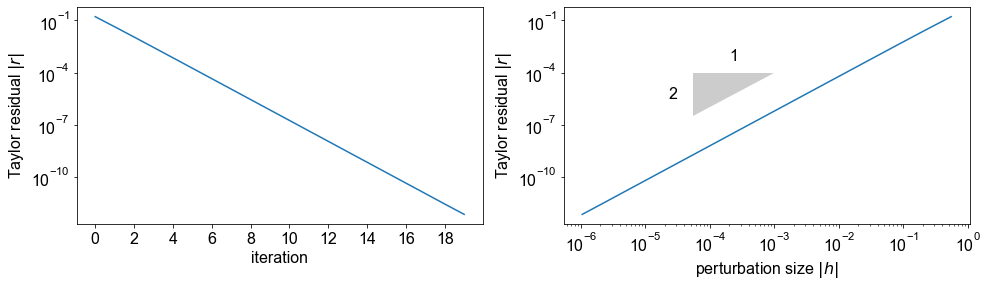

In [14]:
np.random.seed(0)  #  (* see note 2 below)
m_points = 3.1

h0 = np.random.random((1))

taylor_test(u, dudm, m_points, h0)

# Question B9


The discrete version of the functional is given by:

$$
  f(\vec u) = \left(\vec u - \vec u_{\text{end}}\right)^T \left(\vec u - \vec u_{\text{end}}\right)
$$

and implemented below:

In [9]:
img1 = np.load('rsm-blurred.npy')
u_end = img1.flatten()

def f(u):
    """Functional, return l2norm error (misfit) between final timestep solution u and u_end"""
    return (u-u_end) @ (u-u_end)

we also define a little helper function that computes $f(\vec u(m))$:

In [10]:
def fhat(m):
    """Reduced functional, for given m evaluate the diffusion model to get u(m), and subtitute in functional."""
    return f(u(m))

* Write a python function `dfdm` that computes:
$$
  \frac{\mathrm{d}f(\vec u(m))}{\mathrm{d}m} = \left.\frac{\partial f(\vec u)}{\partial\vec u}\right|_{\vec u=\vec u(m)}\cdot\frac{\mathrm{d}\vec u}{\mathrm{d}m}
$$
Write a test that verifies the gradient is correct.

***

In [11]:
def dfdm(m):
    du = dudm(m)
    dfdu = 2*np.subtract(u(m),u_end)
    return dfdu @ du

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.80068864 1.88773514 1.93996083 1.96887907 1.98414601 1.99199715
 1.99597929 1.99798478 1.99899117 1.99949528 1.9997475  1.99987395
 1.99993707 1.99997041 2.0000137  1.99998503 2.00018374 2.00233684
 1.99930453]


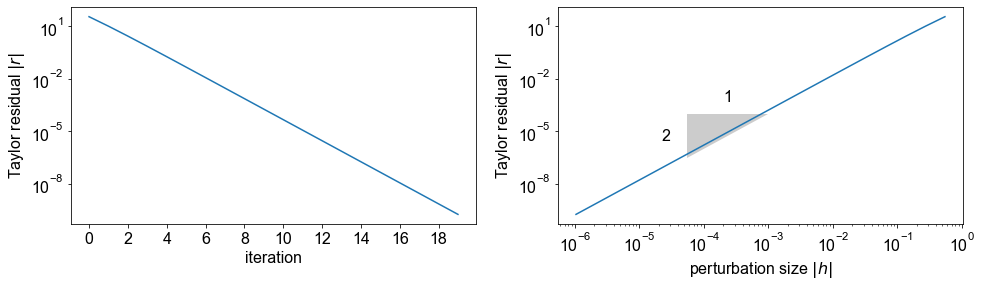

In [12]:
# m_points = np.arange(Nx * Ny)

# h0 = np.random.random((Nx * Ny))
np.random.seed(0)  #  (* see note 2 below)
m_points = 1.

h0 = np.random.random(1)

taylor_test(fhat, dfdm, m_points, h0)

# Question B10

We decide to use the following minimisation algorithm:

In [13]:
def optimize(dfdm, m0):
    """Algorithm to find stationary point for f(m) by solving df(m)/dm=0
    
    dfdm: a function that returns the gradient of f
    m0: initial guess"""
    
    m_i = m0
    for i in range(100):  # fixed number of maximum iterations
        gradf_i = dfdm(m_i)
        # stopping criterion
        if abs(gradf_i) < 1e-5:
            break
        
        if i>0:
            # approximate the second derivative:
            hess = (gradf_i - gradf_prev) / (m_i - m_prev)
        else:
            # first step: no good approximation, but value should be
            # large enough to ensure the initial step is small
            hess = 100.
        
        # store previous values:
        gradf_prev = gradf_i
        m_prev = m_i
            
        # update step:
        m_i = m_prev - gradf_i/hess
        print('Iteration {}, value: {}'.format(i, m_i))
    else:
        print('Maximum number of iterations reached!')
        
    return m_i

* What is the specific name of the algorithm above, a variant of the Newton method? Why can we not use the standard Newton method? Use the above code to find the value of $m$ that was used to blur the photo. You will find that your initial guess needs to be roughly between 1 and 5. The algorithm does not converge for many values outside that range. Is this to be expected, and how could we improve it? (You do not need to actually implement this improvement)
***
### Solution B10


* Quasi-Newton Methods

* Why can we not use the standard Newton method? 
 1. For general functions $f$, the Hessian will not always be SPD. In particular it might not even be invertible, in which case Newton's method immediately breaks down. In addition, if the Hessian is not SPD means that the function $f$ does not necessarily decrease in the chosen direction $\vec p$!. Even if  the Hessian is SPD, we can not ensure convergence. 
 2.Computing the accurate Hessian is expensive 
* Use the above code to find the value of $m$ that was used to blur the photo
  from the code below, we can see that m is around **3.141589**
* Is this to be expected, and how could we improve it? (You do not need to actually implement this improvement)
  Using trust region method to improve it
  
  1.This difference will be most notable in regions where the Hessian $f''$ is not SPD. As we noted before, if $f''$ is not SPD the Newton direction is not necessarily a descent direction and it is therefore not guaranteed that a backtracking line search method will actually converge to an acceptable new point. The Steepest Descent method actually completely ignores the Hessian so is generally well-behaved. One can therefore interpret the Newton trust region method as a modification to the Hessian (by the addition of $\mu\mat I$) to ensure that the modified Hessian is SPD.
  
  2.To actually compute the specific $\mu$ that corresponds to a specific size of the trust region, so that $|\xtr-\vec x_0|=\delta$, is not entirely straight-forward and can be costly. There are therefore several approaches and approximations (Dogleg, Hook, Powell's method) to find a suitable $\mu$, which we'll not go into here.
  

From below codes, we can see that the optimal value of m is around 3.141589, and when m not in [1,5] this method is not convergent.

In [14]:
m_points = 2
optimize(dfdm, m_points)

Iteration 0, value: 2.497539927688579
Iteration 1, value: 2.8674020908603017
Iteration 2, value: 3.071332660682556
Iteration 3, value: 3.133560001398327
Iteration 4, value: 3.141349466599892
Iteration 5, value: 3.141589171570645
Iteration 6, value: 3.1415899999144723


3.1415899999144723

In [15]:
m_points = 1
optimize(dfdm, m_points)

Iteration 0, value: 3.0666892279566356
Iteration 1, value: 3.085694265533108
Iteration 2, value: 3.1398128470617945
Iteration 3, value: 3.1415475738710423
Iteration 4, value: 3.141589967643482


3.141589967643482

In [16]:
m_points = 6
optimize(dfdm, m_points)

Iteration 0, value: 5.722939959182635
Iteration 1, value: -2.857865920807048
Iteration 2, value: 5.722939959182635
Iteration 3, value: 5.722939959182635


/Users/zhangweilin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Iteration 4, value: nan


/Users/zhangweilin/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Iteration 5, value: nan
Iteration 6, value: nan
Iteration 7, value: nan
Iteration 8, value: nan
Iteration 9, value: nan


KeyboardInterrupt: 

# Question B11

## Variable Diffusion Coefficient <a class="tocSkip"></a>
To apply a blur effect that varies throughout the photo, we consider a spatially varying diffusion coefficient $m(x,t)$

$$
  \frac{\partial u(x,y,t)}{\partial t} - m(x,t) \frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2} = 0
$$

or in discretised form:
    
$$ 
\frac{u_i^{k+1} - u_i^k}{\Delta t} +
m_i\frac{-u_{i-1}^{k+1} + 2u_{i}^{k+1} -u_{i+1}^{k+1}}{\Delta x^2} + m_i\frac{-u_{i-N_x}^{k+1} + 2u_{i}^{k+1} - u_{i+N_x}^{k+1}}{\Delta y^2} = 0 $$

where $m_i$ are the entries of a vector $\vec m$ storing the different values of the diffusion coefficient at the grid points.

Again, we can write this as a linear system

$$
  \mat A \vec u^{k+1} = \vec u^k
$$

where now

$$
  \mat A = \mat I + \Delta t~\mat{diag}(\vec m)~\mat K
$$

with $\mat{diag}(\vec m)$ the diagonal matrix whose only nonzero entries are along the main diagonal, and are given by the entries of $\vec m$.

The implementation is given below:

In [14]:
def A_matrix(Nx, Ny, m, delta_t=1.0, delta_x=1.0):
    """Assemble discrete timestepping matrix A for diffusion equation
    with variable diffusion
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    delta_t: time step
    delta_x: grid distance
    """

    n = Ny * Nx
    K = K_matrix(Nx, Ny, delta_x)
    A = sp.eye(n) + delta_t * sp.diags(m) @  K
        
    return A

* Show that the matrix $\mat A$ is *not* symmetric (either by mathematical proof or by experiment), assuming the values of $\vec m$ are not all the same.

$$
  \mat A = \mat I + \Delta t~\mat{diag}(\vec m)~\mat K
$$

$$
  \mat{A}^\mathrm{T} = \mat I + \Delta t~\mat K\mat{diag}(\vec m)
$$

Because $\mat K\mat{diag}(\vec m) \neq \mat{diag}(\vec m)~\mat K $ when the values of $\vec m$ are not all the same.

So $\mat A \neq \mat{A}^\mathrm{T}$ which means that $ \mat A $ is not symmetric 

In [15]:
M = np.random.random(Nx*Ny)

A = A_matrix(Nx, Ny, M)

rows, cols = A.shape
condition = False
for i in range(rows):
    for j in range(cols):
        if i <= j:
            continue
        if A[i,j] != A[j,i]:
            print("this is not a symmetric matrix")
            condition = True
            break
    if condition:
        break

if not condition:
    print("this is not a symmetric matrix")

this is not a symmetric matrix


# Question B12

We now need to redefine the `diffusion_model` based on the new `A_matrix`. This code works exactly as before, except we now return not just the solution at the last timestep, but also all inbetween solutions in a list:

In [16]:
def diffusion_model(Nx, Ny, m, u0, Nt, delta_t=1.0, delta_x=1.0):
    """Solve diffusion equation with variable diffusion,
    and return the solution in all timesteps
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    """

    A = A_matrix(Nx, Ny, m, delta_t=delta_t, delta_x=delta_x)
    u = []
    ui = u0
    for i in range(Nt):
        ui = spl.spsolve(A, ui)
        u.append(ui)
    return u

We use the model on a different photo, and run the model to apply the blurring effect.

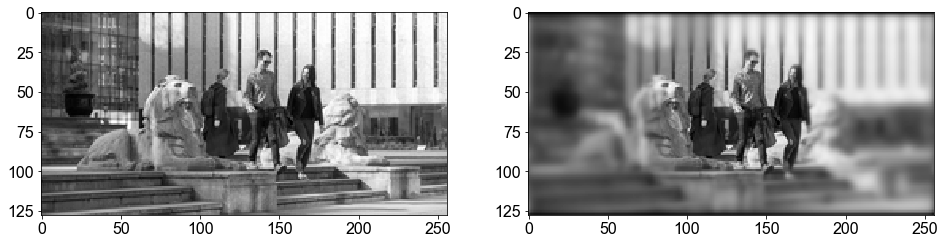

In [17]:
# read the input image, which forms the initial condition u_ic:
img = plt.imread('queens.png')
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(img, cmap='gray')

# This sets up the  spatially varying diffusion coefficient in an array m
# that increases towards the boundaries
# However, after this cell we will "forget" what m was, and try to retreive it
# by solving the optimisation problem described further below
Ny, Nx = img.shape
x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
x0 = Nx/2.; y0 = Ny/2.
m_grid = np.exp(-1/100./(((x-x0)/Nx/0.75)**4+((y-y0)/Ny/1.2)**4+1e-10))
m = m_grid.flatten()
# apply the filter based on this vector m:
u0 = img.flatten()
u = diffusion_model(Nx, Ny, m, u0, 5)

# plot the resulting image, and store it in a file to be used as u_end later
img1 = u[-1].reshape(img.shape)  # image based on the final timestep solution u[-1]
np.save('queens-blurred.npy', img1)
ax[1].imshow(img1, cmap='gray');

After applying the filter, again we have lost the vector of diffusion coefficients $\vec m$. Like before, we would like to recover these values using a PDE-constrained optimisation problem using the same functional $f(u, m)$ as before. This time we formulate it as a *discrete optimisation problem*:

$$
  \text{minimize } f(\vec u, \vec m) = \left(\vec u^{N_t}-\vec u_{\text{end}}\right)^T \left(\vec u^{N_t}-\vec u_{\text{end}}\right)
$$

subject to the discrete PDE constraint

$$
g(\vec u, \vec m) = 
\begin{pmatrix}
\mat A & 0 & 0 & 0 & \cdots & 0\\
-\mat I & \mat A & 0 & 0 &\cdots & 0\\
0 & -\mat I & \mat A & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \cdots & 0 \\
0 & 0 & \cdots & -\mat I & \mat A & 0\\
0 & 0 & \cdots &0 & -\mat I & \mat A
\end{pmatrix}
\begin{pmatrix}
  \vec u^1 \\
  \vec u^2 \\
  \vec u^3 \\
  \vdots \\
  \vec u^{N_t-1} \\
  \vec u^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  \vec u_{\text{ic}} \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}
=
\begin{pmatrix}
  0 \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}  
$$

Here the vector $\vec u$ represents the entire discrete solution at all timesteps, and therefore has a length of $N_t\cdot N_x \cdot N_y$, and is composed of (sub)-vectors $\vec u^k$ for the solution at time-step $k$. The above matrix system thus describes the same timestepping sequence as we implemented above in `diffusion_model`:

$$
  \mat A\vec u^1 = \vec u_{\text{ic}} \\
  -\mat I\vec u^1 + \mat A\vec u^2 = 0  \implies  A\vec u^2 = \vec u^1 \\
  \vdots \\
  -\mat I\vec u^{N_t-1} + \mat A\vec u^{N_t} = 0  \implies  A\vec u^{N_t} = \vec u^{N_t-1}
$$

* We decide to solve this optimisation problem using a gradient-based optimisation algorithm, where the gradient is computed using the adjoint technique. Why can we not use the tangent linear approach as before (efficiently)? What are the three steps we need to take to compute this gradient?

the *tangent linear method* is useful for cases with a small number of parameters, and a potentially large number of functionals.

we can compute $d\hat f(m)/dm$ for any $m$ in three steps:

1. Solve the PDE constraint $g(u, m)=0$ to obtain $u=u(m)$

2. Solve the adjoint equation using $m$ and $u(m)$ for $\lambda$, such that $\frac{\partial\mathcal{L}(u, m, \lambda)}{\partial u}=0$

3. The derivative of the reduced functional is now given by

$$
  \frac{d\hat f(m)}{dm} = \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial m} = \frac{\partial f(u,m)}{\partial m} - \lambda\cdot \frac{\partial g(u, m)}{\partial m}
$$

# Question B13

* Derive the (discrete) adjoint equation for this problem. Work out how the resulting linear system can be solved timestep by timestep. In what order are the timesteps best solved?

* Derive the (discrete) adjoint equation for this problem.Work out how the resulting linear system can be solved timestep by timestep



So far we have seen that we can solve for the Lagrange multiplier $\lambda$ associated with the PDE-constraint $g$ by solving the adjoint equation. In the discrete case this looked like

$$
  \underset{\bf U\times U}{\left(\frac{\partial g(u, m)}{\partial u}\right)^T}
  \underset{\bf U\times 1}{\lambda} = \underset{\bf U\times 1}{\left(\frac{\partial f(u,m)}{\partial u}\right)^T}
$$

where $U$ is the number of discretised equations (in time and space). For the continuous case, we learned that $\lambda$ satisfies a PDE that we solve backwards in time and which is related, but not the same as the PDE we solve for $\vec u$.

A natural question is to ask what is the relation between the vector $\lambda$ in the discrete case, and the function $\lambda$ in the continous case.

For simplicity's sake let us assume that the numerical model that corresponds to $g(u, m)=0$ is linear.
As we have seen in the discretised 1D advection example, the structure of 
our model looks like

$$
g(\vec u, \vec m) = 
\begin{pmatrix}
\mat A & 0 & 0 & 0 & \cdots & 0\\
-\mat I & \mat A & 0 & 0 &\cdots & 0\\
0 & -\mat I & \mat A & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \cdots & 0 \\
0 & 0 & \cdots & -\mat I & \mat A & 0\\
0 & 0 & \cdots &0 & -\mat I & \mat A
\end{pmatrix}
\begin{pmatrix}
  \vec u^1 \\
  \vec u^2 \\
  \vec u^3 \\
  \vdots \\
  \vec u^{N_t-1} \\
  \vec u^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  \vec u_{\text{ic}} \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}
=
\begin{pmatrix}
  0 \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}  
$$
where each of the $\mat A_{n,n}$ and $\mat A_{n,n-1}$ are $N_x\times N_x$ blocks for each time level $n$, $1\leq n \leq N_t$, and
we have split up the solution vector $\vec u$ of length $N_t\cdot N_x$ into $N_t$ vectors $\vec u^n$ of length $N_x$ corresponding to the numerical solution at each time level. The $\vec b^n$ are forcing terms at each time level. For explicit finite difference models the diagonal block $\mat A^{n,n}$ is simply the identity matrix, so we can work out the solution $\vec u^n$ for time level $n$ directly, as all other references are to the previous time level $\vec u^{n-1}$ (via the $\mat A^{n, n-1}$ block). In implicit models we need to do a linear solve involving $\mat A^{n,n}$ at each time level.

From now on we will call this model the forward model, as it corresponds to the PDE we solve for $u$ forward in time. Because we assumed forward model (represented by $g(u,m)=0$) is linear, $\partial g/\partial u$ is based on the same matrix:

$$
\begin{pmatrix}
\mat A & 0 & 0 & 0 & \cdots & 0\\
-\mat I & \mat A & 0 & 0 &\cdots & 0\\
0 & -\mat I & \mat A & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \cdots & 0 \\
0 & 0 & \cdots & -\mat I & \mat A & 0\\
0 & 0 & \cdots &0 & -\mat I & \mat A
\end{pmatrix}
$$
The adjoint equation gives rise to a linear system of the following form
$$
  \begin{pmatrix}
\mat A^T & -\mat I & 0 & 0 & \cdots & 0\\
0 & \mat A^T & -\mat I & 0 &\cdots & 0\\
0 & 0 & \mat A^T & -\mat I & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \cdots & 0 \\
0 & 0 & \cdots & 0 & \mat A^T & -\mat I\\
0 & 0 & \cdots &0 & 0 & \mat A^T
\end{pmatrix}
  \begin{pmatrix}
    \vlam^1 \\ \vlam^2 \\ \vlam^3 \\ \vdots \\ \vlam^{N_t-1} \\ \vlam^{N_t}
  \end{pmatrix}
=
  \begin{pmatrix}
    \frac{\partial f}{\partial \vec u^1} \\ 
    \frac{\partial f}{\partial \vec u^2} \\ 
    \frac{\partial f}{\partial \vec u^3} \\ 
    \vdots \\
    \frac{\partial f}{\partial \vec u^{N_t-1}} \\ 
    \frac{\partial f}{\partial \vec u^{N_t}} \\ 
  \end{pmatrix}
= 
  \begin{pmatrix}
    0 \\ 
    0 \\ 
    0 \\ 
    \vdots \\
    0 \\ 
    2(\vec u^{N_t}-\vec u_{end}) \\ 
  \end{pmatrix},
$$

Note that the natural way to solve this system is to actually go backwards through the time levels, i.e. first we solve the last row:

$$
  \mat A^T \vlam^{N_t} = \frac{\partial f}{\partial \vec u^{N_t}} = 2(\vec u^{N_t}-\vec u_{end}),
$$

then using $\vlam^{N_t}$, we solve for $\vlam^{N_t-1}$

$$
  \mat A^T \vlam^{N_t-1} - \vlam^{N_t} = \frac{\partial f}{\partial \vec u^{N_t-1}} = 0,
$$

etc.

Thus we see that for a discrete PDE-constrained optimisation problem, the adjoint equation leads to a numerical model that is solved backwards in time. The discrete adjoint solution $\vlam$ can in fact be interpreted as a discrete version of the continuous solution $\lambda(x, t)$ to the backwards adjoint PDE that we would have obtained by formulating the same optimisation as a continous problem. It is however *not* generally the case that if we start with the continuous formulation, derive the continuous backward PDE and then choose a suitable discretisation method for that PDE, that we would obtain the same discrete solution $\vlam$ - the difference being a discetisation error.

* In what order are the timesteps best solved?
  **backwards in time to solve**

# Question B14

We provide you with following code, implementing the backward model (which you should be able to relate to your previous answer):

In [18]:
def backward_model(Nx, Ny, m, Nt, u_Nt):
    """Solve adjoint equation and return the adjoint solution in all timesteps
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    u_Nt: forward solution in last timestep
    """
    A = A_matrix(Nx, Ny, m)
    lam = 2*(u_Nt - u_end)  # right-hand side in last time step
    
    # first collect solutions in reverse order:
    lambdas = []  
    for i in range(Nt):
        lam = spl.spsolve(A.T, lam)
        lambdas.append(lam)
        
    
    # then reverse the list, so that the returned list is in the correct order
    return lambdas[::-1]


Again, we define

$$
  \hat f(\vec m) = f(\vec u(\vec m), \vec m)
$$

where $\vec u(\vec m)$ is the "forward" solution to the discretised PDE $g(\vec u,\vec m)=0$. This is implemented below:

In [19]:
img1 = np.load('queens-blurred.npy')
Ny, Nx = img1.shape
Nt = 5
u_end = img1.flatten()

def f(u_Nt):
    """Functional based on final-timestep forward solution"""
    return (u_Nt-u_end) @ (u_Nt-u_end)

def fhat(m):
    """Reduced functional: compute forward solution for given array of grid-point diffusion coefficients
    and subtitute into functional"""
    u = diffusion_model(Nx, Ny, m, u0, Nt)
    fu = f(u[-1])
    print('f(u(m)): ', fu)
    return fu

* Implement the derivative $\mathrm{d}\hat f(\vec m)/\mathrm{d}\vec m$ in a python function `dfdm`. As always, test your derivative: i.e. write a test that verifies that `dfdm` is a derivative of `fhat` above.

**Hint**:
You may use the following expression:

\begin{align*}
  \left(\vlam^T \frac{\partial g(\vec u, \vec m)}{\partial\vec m}\right)_i
  =\sum_{k=1}^{N_t} \Delta t\lambda^k_i \left(\mat K\vec u^k\right)_i
\end{align*}

where $\lambda^k_i$ is the $i$ entry of the adjoint solution $\vlam^k$ at timestep $k$ (the $i$th entry in the $k$th array of the list of arrays returned by `backward_model`). Note that there is no summation over $i$ in the last expression: the shape of the matrix $\partial g/\partial\vec m$ is $(Nt\cdot n)\times n$, so $\vlam^T \partial g/\partial\vec m$ is a $n$-vector whose $i$-th entry is given above. Similarly $(\mat K\vec u^k)_i$ means the $i$-th entry of the vector given by the matrix-vector multiplication $\mat K\vec u^k$ where $\vec u^k$ is the solution in the $k$-th timestep (returned as a list of arrays by `diffusion_model`).

### Solution B14
From B13 this equation:
$$
 \begin{pmatrix}
    \frac{\partial f}{\partial \vec u^1} \\ 
    \frac{\partial f}{\partial \vec u^2} \\ 
    \frac{\partial f}{\partial \vec u^3} \\ 
    \vdots \\
    \frac{\partial f}{\partial \vec u^{N_t-1}} \\ 
    \frac{\partial f}{\partial \vec u^{N_t}} \\ 
  \end{pmatrix}
= 
  \begin{pmatrix}
    0 \\ 
    0 \\ 
    0 \\ 
    \vdots \\
    0 \\ 
    2(\vec u^{N_t}-\vec u_{end}) \\ 
  \end{pmatrix},
$$

we can confirm that $ f(\vec u, \vec m) $ is irrelevant with m, so $ \frac{\partial f(u,m)}{\partial m} =  0$

Then, we can get 
$$
  \frac{d\hat f(m)}{dm} = \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial m} = - \lambda\cdot \frac{\partial g(u, m)}{\partial m}
$$

In [26]:
def dfdm(m):
    K = K_matrix(Nx, Ny)
    A = A_matrix(Nx, Ny, m)
    delta_t = 1
    u_nt = diffusion_model(Nx, Ny, m, u0, Nt)[-1]
    lambdas = backward_model(Nx, Ny, m, Nt, u_nt)[::-1]

#     def df_dm(Nt):
#         fm_list = []
#         result_dfdm = 0.0
#         for nt in range(Nt):
#             if nt == 0:
#                 df_m = 0
#                 continue
#             df_m = nt * delta_t * K @ np.power(A, nt-1) @ u_end
#             result_dfdm += df_m

#         return result_dfdm

    def dgdm(Nt):
        u = u_end

        result_dgdm = 0.0
        for i in range(Nt):
            dg_m = delta_t * lambdas[i] @ (K @ u)
            u = A @ u
            result_dgdm += dg_m

        return result_dgdm
    return -dgdm(Nt)
#     return (df_dm(Nt) - dgdm(Nt))

In [27]:
dfdm(m)

-0.0

Using the taylor test to verify  that `dfdm` is the derivative of `fhat`

In [28]:
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0.copy()
    residuals = []
    hnorms = []
    dfdx = grad_f(x)
    for i in range(max_iter):
        r = f(x + h) - f(x) - np.sum(dfdx * h)
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((1e-2, 1e-3), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

In [29]:
m.shape

(32768,)

In [30]:
np.random.seed(0) 
# h0 = np.random.random(m.shape)
h0 = u0

f(u(m)):  150.1576109789567
f(u(m)):  0.0
f(u(m)):  75.0388034948879
f(u(m)):  0.0
f(u(m)):  34.95777336957393
f(u(m)):  0.0
f(u(m)):  14.626930874842818
f(u(m)):  0.0
f(u(m)):  5.353704731208043
f(u(m)):  0.0
f(u(m)):  1.7196795301917613
f(u(m)):  0.0
f(u(m)):  0.49887411868254655
f(u(m)):  0.0
f(u(m)):  0.13538426155057154
f(u(m)):  0.0
f(u(m)):  0.035342540679912396
f(u(m)):  0.0
f(u(m)):  0.009034328001892388
f(u(m)):  0.0
f(u(m)):  0.0022841969741063148
f(u(m)):  0.0
f(u(m)):  0.000574301484508691
f(u(m)):  0.0
f(u(m)):  0.00014398510510972668
f(u(m)):  0.0
f(u(m)):  3.604769504193355e-05
f(u(m)):  0.0
f(u(m)):  9.01836378808611e-06
f(u(m)):  0.0
f(u(m)):  2.2553967448552853e-06
f(u(m)):  0.0
f(u(m)):  5.639499606467257e-07
f(u(m)):  0.0
f(u(m)):  1.410000900743727e-07
f(u(m)):  0.0
f(u(m)):  3.5251597702228355e-08
f(u(m)):  0.0
f(u(m)):  8.813096335538402e-09
f(u(m)):  0.0
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.00076887 1.10202353 1.25698621 1.45001761 1.63839784

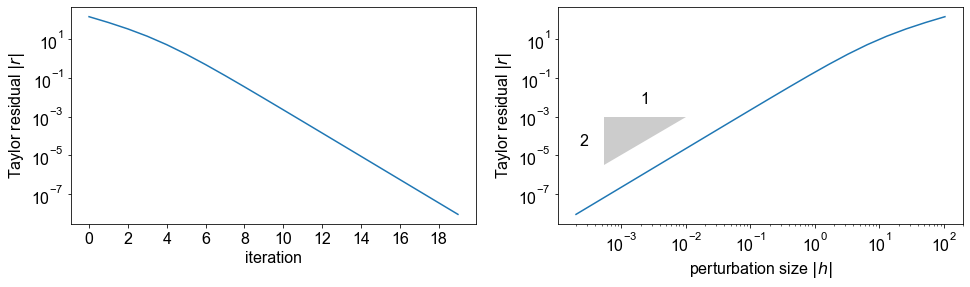

In [31]:
taylor_test(fhat, dfdm, m, h0)

From above picture which shows that the convergence order is 2 we can verify that `dfdm` is the derivative of `fhat`